In [2]:
import pandas as pd
import os
import geopandas as gpd
import numpy as np
import fiona
from shapely.geometry import shape
import matplotlib.pyplot as plt
from shapely.ops import unary_union
from shapely.geometry import box
import matplotlib.patches as patches
from functions import *

### Load data

In [3]:
dir_path = '../data/external/water_stations_data/discharge'
#dir_path = '../../tfg/data/15994_4699_2024-10-31_11-54-16'
stations_meta = pd.read_excel('../data/external/Stationsliste_HydrowebSAM_EN_july2023.xlsx',skiprows=range(0,4))
stations_meta.rename(columns={'Station number': 'Stationsnummer'}, inplace=True)
stations_meta.drop_duplicates(subset = ['Stationsnummer'], inplace=True)

### Obtain georeference about stations that have data

In [4]:
stations_ds={}
new_df = pd.DataFrame()
for file in os.listdir(dir_path):
    if file.endswith('.csv'):
        df = pd.read_csv(os.path.join(dir_path, file), delimiter=';', encoding='latin1', skiprows=range(0,8))
        st_number = df.Stationsnummer.unique()
        st_number_str = st_number[0]
        
        if len(st_number) > 1:
            i = 1
            while st_number_str == 'Stationsnummer' or np.isnan(float(st_number_str)):
                st_number_str = st_number[i]
                i+=1
            print('More than one station number')
        print(st_number_str)
        if st_number_str in stations_meta['Stationsnummer'].values:
            print('Station number found')
            new_df = pd.concat([new_df,stations_meta[stations_meta['Stationsnummer']==st_number_str]])
            
        d = "2013-03-01"
        df = df[df.Zeitstempel >= d]
        stations_ds[st_number_str] = df
            

2403
Station number found
2620
Station number found
2185
Station number found
2416
Station number found
2462
Station number found
2268
Station number found
2016
Station number found
2263
Station number found
2087
Station number found
2327
Station number found
2333
Station number found
2084
Station number found
155
Station number found
2412
Station number found
352
Station number found
2447
Station number found
2387
Station number found
2156
Station number found
2646
Station number found
2067
Station number found
2461
Station number found
2151
Station number found
2239
Station number found
2053
Station number found
2091
Station number found
2469
Station number found
2418
Station number found
2640
Station number found
More than one station number
2319
2187
Station number found
2351
Station number found
2135
Station number found
2605
Station number found
2079
Station number found
2034
Station number found
2112
Station number found
2300
Station number found
2488
Station number found
2288
S

In [5]:
stations_ds[2161]

,Stationsname,Stationsnummer,Parameter,Zeitreihe,Parametereinheit,Gewässer,Zeitstempel,Zeitpunkt_des_Auftretens,Wert,Freigabestatus
2,Blatten bei Naters,2161,Abfluss,Monatsmittel,m3/s,Massa,2013-03-01 00:00:00,NaN,0.402,"Freigegeben, validierte Daten"
3,Blatten bei Naters,2161,Abfluss,Monatsmittel,m3/s,Massa,2013-04-01 00:00:00,NaN,2.141,"Freigegeben, validierte Daten"
4,Blatten bei Naters,2161,Abfluss,Monatsmittel,m3/s,Massa,2013-05-01 00:00:00,NaN,7.531,"Freigegeben, validierte Daten"
5,Blatten bei Naters,2161,Abfluss,Monatsmittel,m3/s,Massa,2013-06-01 00:00:00,NaN,26.655,"Freigegeben, validierte Daten"
6,Blatten bei Naters,2161,Abfluss,Monatsmittel,m3/s,Massa,2013-07-01 00:00:00,NaN,47.019,"Freigegeben, validierte Daten"
...,...,...,...,...,...,...,...,...,...,...
136,Blatten bei Naters,2161,Abfluss,Monatsmittel,m3/s,Massa,2024-05-01 00:00:00,NaN,10.916,"Freigegeben, geprüfte Daten"
137,Blatten bei Naters,2161,Abfluss,Monatsmittel,m3/s,Massa,2024-06-01 00:00:00,NaN,41.183,"Freigegeben, geprüfte Daten"
138,Blatten bei Naters,2161,Abfluss,Monatsmittel,m3/s,Massa,2024-07-01 00:00:00,NaN,68.315,"Freigegeben, geprüfte Daten"
139,Blatten bei Naters,2161,Abfluss,Monatsmittel,m3/s,Massa,2024-08-01 00:00:00,NaN,64.560,"Freigegeben, geprüfte Daten"


### Obtain grid cells sorrounding every station

In [6]:
crs_original = "EPSG:2056"  # o usa "EPSG:21781" si las coordenadas están en LV03

# Convertir el DataFrame de pandas a un GeoDataFrame de geopandas
gdf = gpd.GeoDataFrame(
    new_df,
    geometry=gpd.points_from_xy(new_df["X-Coordinate"], new_df["Y-Coordinate"]),
    crs=crs_original
)

# Proyectar al CRS deseado, por ejemplo WGS84 (EPSG:4326)
gdf = gdf.to_crs("EPSG:4326")

<Axes: >

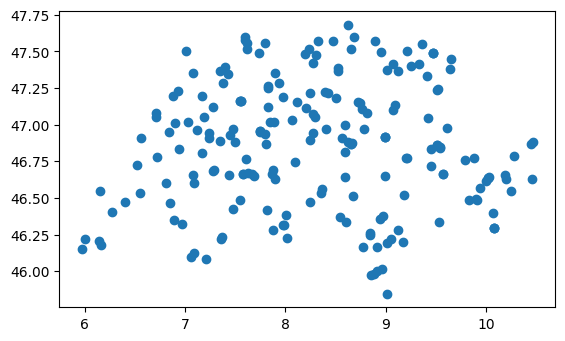

In [7]:
gdf.plot()

EPSG:4326


/home/ruth.parajo/miniconda3/lib/python3.12/site-packages/contextily/tile.py:645: UserWarning: The inferred zoom level of 24 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


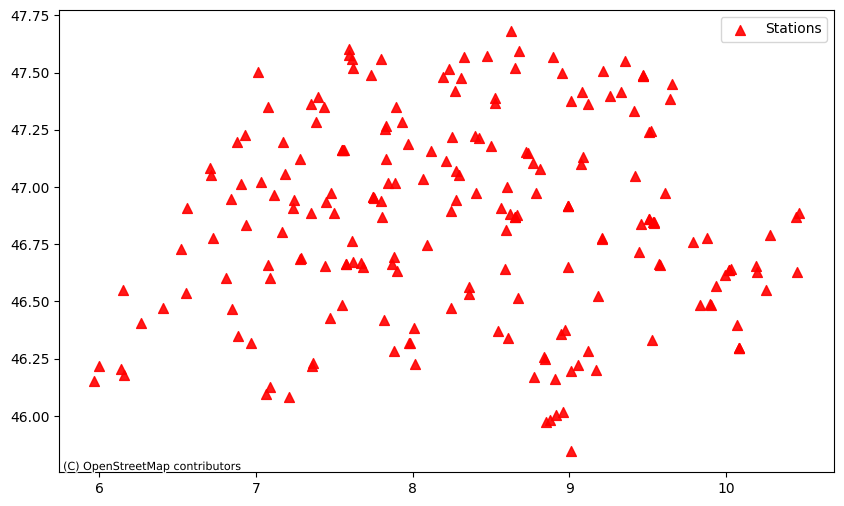

In [9]:
import contextily as ctx
# Leer el shapefile y transformar a EPSG:4326
gdf2 = gpd.read_file('../data/external/shp/Switzerland_shapefile/ch_1km.shp')
gdf2 = gdf2.to_crs("EPSG:2056")
print(gdf.crs)

# Crear la figura y el eje
fig, ax = plt.subplots(figsize=(10, 10))

# Ploteo de los puntos de `gdf`
gdf.plot(ax=ax, color="red", marker="^", markersize=50, alpha=0.9, label="Stations")

#gdf2.boundary.plot(ax=ax, edgecolor = 'blue', label="Boundary of gdf2")


# Añadir mapa base (opcional)
ctx.add_basemap(ax, crs=gdf2.crs, source=ctx.providers.OpenStreetMap.Mapnik)

# Mostrar la leyenda y el gráfico
ax.legend()
plt.show()

#### Create a shp for each cell

In [10]:
water_ds = pd.DataFrame(index = stations_ds[2161].Zeitstempel,columns = range(1,len(gdf)+1))

In [11]:
water_ds

,1,2,3,4,5,6,7,8,9,10,...,198,199,200,201,202,203,204,205,206,207
Zeitstempel,,,,,,,,,,,,,,,,,,,,,
2013-03-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-04-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-05-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-06-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-07-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-06-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-07-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Change the CRS to a projected coordinate system (e.g., UTM appropriate for your region)
gdf = gdf.to_crs("EPSG:32633")  # Make sure to use the correct CRS for your region

# Define the buffer size in meters (10x10 km = 5000 m in each direction from the center point)
buffer_size = 6400

# Create a folder to store the shapefiles if it doesn't exist
output_folder = "../data/external/shp/cells"
os.makedirs(output_folder, exist_ok=True)

cell_data = pd.DataFrame(columns=["Cell", "Latitude", "Longitude"])

river_cells = {}
output_directory = '../data/external/shp/river_cells_oficial'
a=0

for i,riv in enumerate(os.listdir(output_directory)):
    # Check if the file is a shapefile
    try:
        if riv.endswith('.shp'):
            a+=1
            print(f"Processing file: {riv}")
            river = gpd.read_file(os.path.join(output_directory, riv))
            river = river.to_crs("EPSG:4326")
            river_cells[riv.split('station_')[-1].split('.')[0]] = river
            print('Added', riv.split('station_')[-1].split('.')[0])
            
    except:
        print('Not this river')
    



Processing file: station_cell_37.shp
Added cell_37
name 'point' is not defined
Not this river
Processing file: station_cell_8.shp
Added cell_8
name 'point' is not defined
Not this river
Processing file: station_cell_33.shp
Added cell_33
name 'point' is not defined
Not this river
Processing file: station_cell_9.shp
Added cell_9
name 'point' is not defined
Not this river
Processing file: station_cell_42.shp
Added cell_42
name 'point' is not defined
Not this river
Processing file: station_cell_78.shp
Added cell_78
name 'point' is not defined
Not this river
Processing file: station_cell_6.shp
Added cell_6
name 'point' is not defined
Not this river
Processing file: station_cell_46.shp
Added cell_46
name 'point' is not defined
Not this river
Processing file: station_cell_31.shp
Added cell_31
name 'point' is not defined
Not this river
Processing file: station_cell_59.shp
Added cell_59
name 'point' is not defined
Not this river
Processing file: station_cell_63.shp
Added cell_63
name 'point' is

In [14]:
c=1
for idx, point in gdf.iterrows():
    try:
        station_number = point.Stationsnummer
        station_data = stations_ds[station_number]
        water_ds[c] = list(station_data.Wert.values)

    except Exception as e:
        print(e)
        print(station_number,c, len(list(station_data.Wert.values)))
    c+=1

Length of values (62) does not match length of index (139)
2333 11 62
Length of values (136) does not match length of index (139)
2351 30 136
Length of values (138) does not match length of index (139)
2309 51 138
Length of values (103) does not match length of index (139)
2639 56 103
Length of values (136) does not match length of index (139)
2299 104 136
Length of values (46) does not match length of index (139)
2270 126 46
Length of values (136) does not match length of index (139)
2252 134 136
Length of values (39) does not match length of index (139)
2186 168 39
Length of values (136) does not match length of index (139)
2251 182 136


In [15]:
water_ds

,1,2,3,4,5,6,7,8,9,10,...,198,199,200,201,202,203,204,205,206,207
Zeitstempel,,,,,,,,,,,,,,,,,,,,,
2013-03-01 00:00:00,0.969,1.259,0.824,1.276,3.834,0.214,241.330,0.628,2.123,0.370,...,101.443,0.308,3.657,387.390,0.564,105.679,76.535,12.149,4.187,79.588
2013-04-01 00:00:00,1.235,2.539,7.713,1.778,13.225,0.606,494.202,1.248,7.841,1.263,...,141.716,1.036,7.063,732.260,2.213,226.698,143.408,27.070,6.104,149.656
2013-05-01 00:00:00,3.940,6.712,14.200,1.621,34.581,1.620,481.324,3.206,13.680,2.839,...,250.523,1.347,5.755,868.901,6.894,291.301,226.376,22.402,4.313,237.434
2013-06-01 00:00:00,19.091,6.937,18.337,2.194,49.038,6.152,555.743,6.227,22.194,4.844,...,337.491,1.322,2.361,1120.716,9.169,339.567,307.164,25.792,5.986,332.866
2013-07-01 00:00:00,12.021,6.098,7.009,1.143,49.649,12.747,328.907,5.383,18.238,3.820,...,337.819,0.488,1.796,644.033,7.999,224.320,189.595,7.271,2.512,203.237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-01 00:00:00,6.712,5.986,18.077,1.803,40.826,2.383,414.496,4.976,13.653,3.753,...,260.007,1.151,3.470,769.702,8.496,237.402,207.232,21.262,4.568,211.573
2024-06-01 00:00:00,49.880,11.370,24.793,3.330,74.990,7.756,529.848,8.969,28.332,6.792,...,457.059,1.335,1.870,1151.792,13.018,336.151,330.894,22.075,4.409,341.667
2024-07-01 00:00:00,31.770,12.030,11.862,1.979,66.826,11.101,412.620,7.298,16.185,4.972,...,475.067,0.539,0.858,820.925,10.289,284.955,233.440,15.027,2.303,244.022


### Check if river and cell shp are the same

In [21]:
dirr='../data/raw/wt'
os.makedirs(dirr,exist_ok=True)
water_ds.to_csv(f'{dirr}/water_temp.csv',index=True)
cell_data.to_csv(f'{dirr}/cell_coordinates_oficial.csv',index=False)
pd.read_csv(f'{dirr}/water_temp.csv', index_col=0)

,1,2,3,4,5,6,7,8,9,10,...,72,73,74,75,76,77,78,79,80,81
Zeitstempel,,,,,,,,,,,,,,,,,,,,,
2013-03-01 00:00:00,5.76,1.05,2.72,2.91,3.61,5.86,3.23,7.46,6.24,5.59,...,5.96,8.20,4.04,6.69,6.04,6.06,5.48,3.83,4.64,0.96
2013-04-01 00:00:00,8.16,3.23,3.62,5.43,5.91,8.54,5.20,8.94,8.94,8.33,...,8.02,9.92,5.92,9.93,8.77,8.77,8.22,8.19,8.90,1.56
2013-05-01 00:00:00,12.06,5.38,4.49,6.83,8.68,12.21,8.49,9.46,10.16,11.65,...,8.53,10.93,6.86,13.71,10.15,12.35,10.14,10.75,11.26,1.31
2013-06-01 00:00:00,15.15,9.05,5.01,8.56,12.00,15.21,12.85,10.42,13.67,15.12,...,10.90,12.93,8.49,17.17,14.04,15.36,13.41,13.63,15.18,1.31
2013-07-01 00:00:00,19.52,12.63,6.34,10.80,15.42,21.28,17.35,11.98,19.61,20.50,...,13.75,16.97,10.80,20.67,20.99,21.30,17.45,17.22,20.13,1.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-01 00:00:00,13.94,6.03,4.81,7.26,10.67,13.85,11.10,10.58,12.20,13.40,...,10.36,12.10,7.63,15.62,12.29,13.95,11.97,12.41,14.02,1.79
2024-06-01 00:00:00,16.58,9.45,5.38,8.63,13.05,17.00,13.57,11.62,15.24,16.79,...,12.24,13.55,9.03,18.39,15.95,17.04,14.46,14.65,16.51,1.56
2024-07-01 00:00:00,19.75,12.10,6.82,10.47,15.52,20.68,16.94,12.39,18.90,20.38,...,14.30,15.95,10.74,20.82,19.92,20.67,17.49,17.22,19.97,Lücke


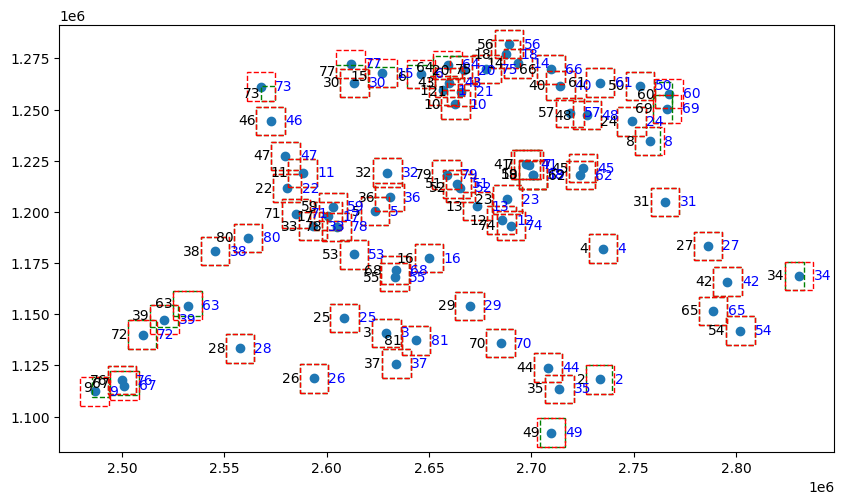

In [19]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf = gdf.to_crs("EPSG:2056")
gdf.plot(ax=ax)
folder = '../data/external/shp/river_cells_oficial'
folder_cells= '../data/external/shp/cells'#_10x10km'
for i in range(1, 82):
    try:
        # Cargar el shapefile de la celda expandida
        cell = os.path.join(folder, f'station_cell_{i}.shp')
        cell_gdf = gpd.read_file(cell)
        expanded_bbox = cell_gdf.total_bounds
    
        # Dibujar la bounding box expandida en el gráfico
        expanded_rect = patches.Rectangle(
            (expanded_bbox[0], expanded_bbox[1]),
            expanded_bbox[2] - expanded_bbox[0],
            expanded_bbox[3] - expanded_bbox[1],
            linewidth=1,
            edgecolor="green",
            facecolor="none",
            linestyle="--"
        )
        ax.add_patch(expanded_rect)
        text_x = expanded_bbox[0] - 100  # Ajuste de posición hacia la derecha
        text_y = (expanded_bbox[1] + expanded_bbox[3]) / 2 
        ax.text(text_x, text_y, str(i), color="black", fontsize=10, ha="right", va="center")
    
    
        cell = os.path.join(folder_cells, f'cell_{i}.shp')
        cell_gdf = gpd.read_file(cell)
        expanded_bbox = cell_gdf.total_bounds
    
        # Dibujar la bounding box expandida en el gráfico
        expanded_rect = patches.Rectangle(
            (expanded_bbox[0], expanded_bbox[1]),
            expanded_bbox[2] - expanded_bbox[0],
            expanded_bbox[3] - expanded_bbox[1],
            linewidth=1,
            edgecolor="red",
            facecolor="none",
            linestyle="--"
        )
        text_x = expanded_bbox[2] + 100  # Ajuste de posición hacia la derecha
        text_y = (expanded_bbox[1] + expanded_bbox[3]) / 2 
        ax.text(text_x, text_y, str(i), color="blue", fontsize=10, ha="left", va="center")
    
        ax.add_patch(expanded_rect)
    except:
        pass

### Other visualizations

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf = gdf.to_crs("EPSG:2056")
gdf.plot(ax=ax)
folder = '../data/external/shp/river_cells_oficial'
folder_cells= '../data/external/shp/cells'#_10x10km'
for i in range(1, 82):
    try:
        # Cargar el shapefile de la celda expandida
        cell = os.path.join(folder, f'station_cell_{i}.shp')
        cell_gdf = gpd.read_file(cell)
        expanded_bbox = cell_gdf.total_bounds
    
        # Dibujar la bounding box expandida en el gráfico
        expanded_rect = patches.Rectangle(
            (expanded_bbox[0], expanded_bbox[1]),
            expanded_bbox[2] - expanded_bbox[0],
            expanded_bbox[3] - expanded_bbox[1],
            linewidth=1,
            edgecolor="green",
            facecolor="none",
            linestyle="--"
        )
        ax.add_patch(expanded_rect)
        text_x = expanded_bbox[0] - 100  # Ajuste de posición hacia la derecha
        text_y = (expanded_bbox[1] + expanded_bbox[3]) / 2 
        ax.text(text_x, text_y, str(i), color="black", fontsize=10, ha="right", va="center")
    
    
        cell = os.path.join(folder_cells, f'cell_{i}.shp')
        cell_gdf = gpd.read_file(cell)
        expanded_bbox = cell_gdf.total_bounds
    
        # Dibujar la bounding box expandida en el gráfico
        expanded_rect = patches.Rectangle(
            (expanded_bbox[0], expanded_bbox[1]),
            expanded_bbox[2] - expanded_bbox[0],
            expanded_bbox[3] - expanded_bbox[1],
            linewidth=1,
            edgecolor="red",
            facecolor="none",
            linestyle="--"
        )
        text_x = expanded_bbox[2] + 100  # Ajuste de posición hacia la derecha
        text_y = (expanded_bbox[1] + expanded_bbox[3]) / 2 
        ax.text(text_x, text_y, str(i), color="blue", fontsize=10, ha="left", va="center")
    
        ax.add_patch(expanded_rect)
    except:
        pass

In [ ]:
a=gpd.read_file(os.path.join(output_folder,'cell_1.shp'))
a.plot()
a.crs

#### Plot all cells

In [ ]:
gdf = gdf.to_crs("EPSG:32633")
buffer_size = 5000  # 10x10 km significa 5 km de radio en cada dirección desde el centro

# Función para crear una celda cuadrada alrededor de cada punto
def create_square(point, size):
    x, y = point.x, point.y
    return box(x - size, y - size, x + size, y + size)

# Aplicamos la función a cada punto en el GeoDataFrame
gdf['geometry'] = gdf.geometry.apply(lambda point: create_square(point, buffer_size))
gdf = gdf.to_crs("EPSG:2056")
gdf.plot(color='none')

### Comparison to old cells

In [ ]:
crs_original = "EPSG:2056"  # o usa "EPSG:21781" si las coordenadas están en LV03

# Convertir el DataFrame de pandas a un GeoDataFrame de geopandas
gdf = gpd.GeoDataFrame(
    new_df,
    geometry=gpd.points_from_xy(new_df["X-Coordinate"], new_df["Y-Coordinate"]),
    crs=crs_original
)

# Proyectar al CRS deseado, por ejemplo WGS84 (EPSG:4326)
gdf = gdf.to_crs("EPSG:4326")

In [ ]:
gdf2 = gpd.read_file('../data/external/shp/Switzerland_shapefile')
gdf2 = gdf2.to_crs("EPSG:4326")
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf2.plot(ax=ax, facecolor="none", edgecolor="green", linewidth=1, label='Preprocessed Cells')
gdf.plot(ax=ax)
